## Machine Learning in Medicine: Skin Lesion Classification
### Submitted by: Nourhan Ibrahim - Ahmed Shamsia - Mohosina Akhter

In [78]:
from medmnist import DermaMNIST
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import seaborn as sns

### Dataset Preprocessing

In [79]:
train_dataset = DermaMNIST(split="train", download=True, size=28)
valid_dataset = DermaMNIST(split="val", download=True, size=28)
test_dataset = DermaMNIST(split="test", download=True, size=28)

In the next cell, the mean and standard deviation of the training set per channel are calculated. The cell needs to run every time the size of the image is changed.

In [80]:
means = []
stds = []
for image in tqdm(train_dataset):
    image_np = np.array(image[0])
    mean = np.mean(image_np, axis=(0, 1))
    std = np.std(image_np, axis=(0, 1))
    means.append(mean)
    stds.append(std)
    
dataset_mean = np.mean(means, axis=0)
dataset_std = np.mean(stds, axis=0)
print(dataset_mean, dataset_std)

100%|██████████| 7007/7007 [00:00<00:00, 8694.69it/s]

[194.59373935 137.21248467 143.15397613] [22.43410183 29.14128907 32.02184949]


To visualize a number of images, change the number inside the montage function. This number refers to how many images per row and column. For example, if the number is set to 10, you will see a block of 10 images by 10 images.

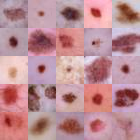

In [81]:
train_dataset.montage(5)

The following function is used for feature extraction and dimensionality reduction. Min-max scaling and conversion to grayscale are applied where needed. First the color histograms of each image are calculated in 256 bins for the intensity levels of each channel. Next the images are gray-scaled for Histogram of Gradients (HOG) features to be extracted. After that a pipeline of min-max scaler and Principal Component Analysis (PCA) is constructed in a way to keep the 0.97 of the cumulative variance in the data. To prevent data leakage from the training to the validation and test sets, the pipeline is fit to the training data only, and then the fitted pipeline is used for transforming all data.

In [82]:
def preprocess_data(data, mode='train', pipeline=None):
    histograms = []
    labels = []
    hogs = []

    for i in range(len(data)):
        histogram = data[i][0].histogram()
        histograms.append(histogram)
        labels.append(train_dataset[i][1])
    histograms = pd.DataFrame(histograms)

    for i in range(len(data)):
        image = data[i][0]
        gray_image = rgb2gray(image)
        # Compute HOG features
        hog_features = hog(gray_image,
                       orientations=9,         # Number of gradient bins
                       pixels_per_cell=(8,8),   # Size of cell
                       cells_per_block=(2,2),   # Size of block
                       block_norm='L2-Hys',     # Normalization method
                       feature_vector=True)     # Output as a single vector
        hogs.append(hog_features)
    hogs = pd.DataFrame(hogs)

    features = pd.concat([histograms, hogs], axis=1)

    if(mode == 'train'):
        pipeline = make_pipeline(MinMaxScaler(), PCA(n_components=0.97))
        pipeline.fit(features)

    features_normalized = pd.DataFrame(pipeline.transform(features))
    return features_normalized, np.array(labels).ravel(), pipeline

In [83]:
train_features, train_labels, pipeline = preprocess_data(train_dataset, mode='train')
valid_features, valid_labels, pipeline = preprocess_data(valid_dataset, pipeline=pipeline, mode='valid')
test_features, test_labels, pipeline = preprocess_data(test_dataset, pipeline=pipeline, mode='test')

In [84]:
test_features.shape

(2005, 344)

The cumulative explained variance for the fitted PCA model is plotted against the number of components kept.

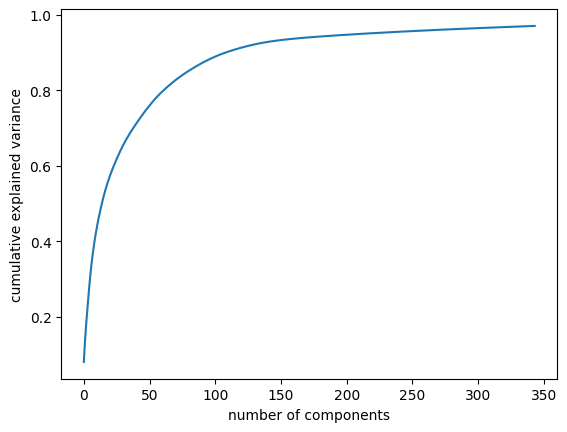

In [85]:
plt.plot(np.cumsum(pipeline['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('PCA.png', dpi=300)

Now to check how balanced the dataset is, the training label counts for the 7 classes are plotted. According to the plot, the dataset is very imbalanced with the majority of the images belonging to class 5.

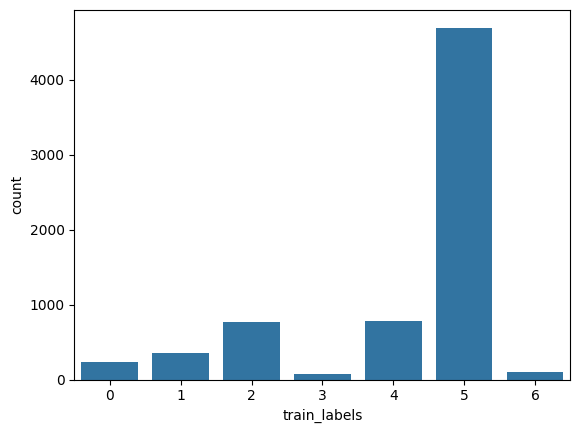

In [86]:
labels_dict = {
    "train_labels": np.array(train_labels).ravel(),
    "valid_labels": np.array(valid_labels).ravel(),
    "test_labels": np.array(test_labels).ravel(),
}
sns.countplot(labels_dict, x="train_labels")
plt.savefig("train_labels_counts.png", dpi=300)

The training and validation sets are then concatenated together since cross validation will be used later anyway for hyperparameter optimization.

In [87]:
X_train = pd.concat([train_features, valid_features], axis = 0).reset_index(drop=True)
y_train = np.append(train_labels, valid_labels)

## Logistic Regression

The first classifier to be tried is logistic regression. The solver is set to "newton-cg" since it is one of the few solvers that can handle multiclass problems well. Since the dataset is imbalanced, the class weights are set to "balanced" to build a better model. The regularization parameter C is left at the default value as 1.0 in the first cell.

In [88]:
clf = LogisticRegression(solver="newton-cg", class_weight="balanced", random_state=0, verbose=0)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores.mean()

np.float64(0.45742821473158546)

In the next cell, the C hyperparameter is optimized using Grid Search Cross Validation. The best parameter will be used later for fitting the model.

In [89]:
clf = LogisticRegression(solver="newton-cg", class_weight="balanced", random_state=0, verbose=0)
hyperparameter = {'C' : np.linspace(0.1, 1, 10).tolist()}
grid_search = GridSearchCV(estimator=clf, param_grid=hyperparameter , scoring='accuracy', cv=5, n_jobs=-1 , verbose=2)
grid_scores = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..............................................C=0.1; total time=   1.4s
[CV] END ..............................................C=0.1; total time=   1.8s
[CV] END ..............................................C=0.1; total time=   1.9s
[CV] END ..............................................C=0.1; total time=   1.9s
[CV] END ..............................................C=0.2; total time=   2.0s
[CV] END ..............................................C=0.1; total time=   2.0s
[CV] END ..............................................C=0.2; total time=   2.0s
[CV] END ..............................................C=0.2; total time=   2.1s
[CV] END ..............................................C=0.2; total time=   2.1s
[CV] END ..............................C=0.30000000000000004; total time=   2.2s
[CV] END ..............................C=0.30000000000000004; total time=   2.1s
[CV] END ..............................C=0.30000

In [90]:
print(grid_search.best_score_)
print(grid_search.best_params_['C'])

0.45767790262172287
0.9


The best C parameter is 0.9. It will now be used with stratified K Fold Cross Validation to fit and evaluate the model.

In [91]:
skf = StratifiedKFold(n_splits=5)
clf = LogisticRegression(solver="newton-cg", class_weight="balanced", C=grid_search.best_params_['C'], random_state=0, verbose=0)
accuracies = []
for train, valid in skf.split(X_train, y_train):
    X_fold_train = X_train.iloc[train, :]
    y_fold_train = y_train[train]
    X_fold_valid = X_train.iloc[valid, :]
    y_fold_valid = y_train[valid]
    clf.fit(X_fold_train, y_fold_train)
    accuracies.append(clf.score(X_fold_valid, y_fold_valid))
print(np.mean(accuracies))

0.45767790262172287


In [92]:
y_true = test_labels
y_pred = clf.predict(test_features)
target_names = ['actinic keratoses and intraepithelial carcinoma', 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
print(metrics.classification_report(y_true, y_pred, zero_division=0, target_names=target_names))

                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.02      0.06      0.03        71
                           basal cell carcinoma       0.04      0.06      0.05       104
                  benign keratosis-like lesions       0.12      0.13      0.13       210
                                 dermatofibroma       0.01      0.04      0.01        24
                                       melanoma       0.12      0.18      0.14       223
                               melanocytic nevi       0.67      0.43      0.53      1338
                               vascular lesions       0.02      0.06      0.02        35

                                       accuracy                           0.33      2005
                                      macro avg       0.14      0.14      0.13      2005
                                   weighted avg       0.47      0.33      0.38      2005



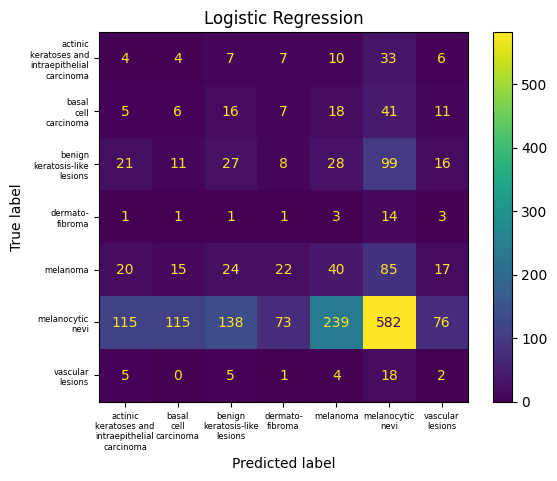

In [93]:
cm = metrics.confusion_matrix(y_true, y_pred)
target_names = ['actinic\nkeratoses and\nintraepithelial\ncarcinoma', 'basal\ncell\ncarcinoma', 'benign\nkeratosis-like\nlesions', 'dermato-\nfibroma', 'melanoma', 'melanocytic\nnevi', 'vascular\nlesions']
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
# plt.xticks(rotation=30)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.yticks(wrap=True)
plt.xticks(wrap=True)
plt.title("Logistic Regression")
plt.savefig('confusion_matrix_LR.png', dpi=300)

## KNN

The second classifer to be tried is K Nearest Neighbors. At first, a simple model is used with 5 neighbors. The number of neighbors was chosen by trial and error.

In [94]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [95]:
y_true = test_labels
y_pred = knn.predict(test_features)
target_names = ['actinic keratoses and intraepithelial carcinoma', 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
print(metrics.classification_report(y_true, y_pred, zero_division=0, target_names=target_names))

                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.03      0.04      0.03        71
                           basal cell carcinoma       0.05      0.05      0.05       104
                  benign keratosis-like lesions       0.12      0.11      0.12       210
                                 dermatofibroma       0.00      0.00      0.00        24
                                       melanoma       0.14      0.12      0.13       223
                               melanocytic nevi       0.67      0.71      0.69      1338
                               vascular lesions       0.00      0.00      0.00        35

                                       accuracy                           0.50      2005
                                      macro avg       0.14      0.15      0.15      2005
                                   weighted avg       0.48      0.50      0.49      2005



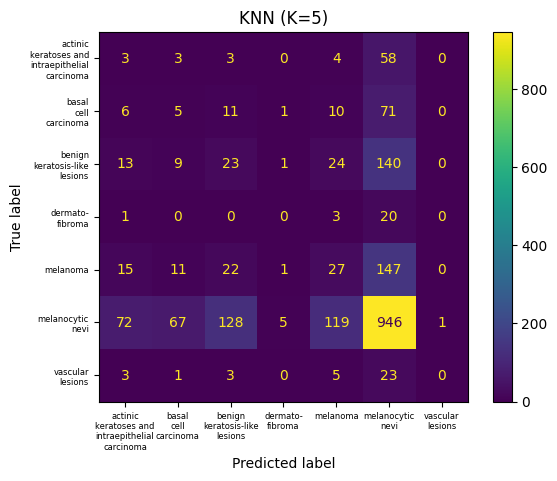

In [96]:
cm = metrics.confusion_matrix(y_true, y_pred)
target_names = ['actinic\nkeratoses and\nintraepithelial\ncarcinoma', 'basal\ncell\ncarcinoma', 'benign\nkeratosis-like\nlesions', 'dermato-\nfibroma', 'melanoma', 'melanocytic\nnevi', 'vascular\nlesions']
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
# plt.xticks(rotation=30)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.yticks(wrap=True)
plt.xticks(wrap=True)
plt.title("KNN (K=5)")
plt.savefig('confusion_matrix_KNN.png', dpi=300)

The data imbalance badly affects the KNN model. To try and balance the data, SMOTE is used to resample the minority classes.

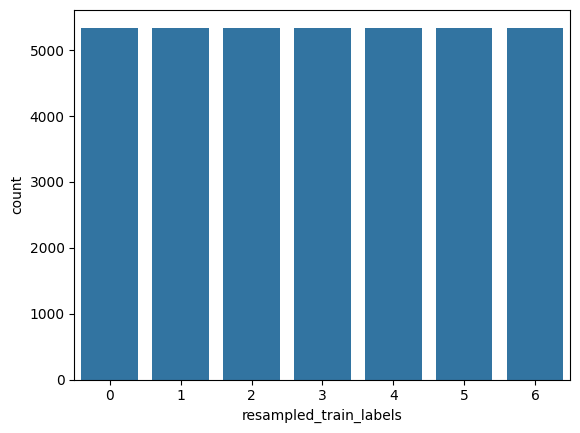

In [97]:
smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(train_features, train_labels)
X_valid, y_valid = smote.fit_resample(valid_features, valid_labels)
X_test, y_test = smote.fit_resample(test_features, test_labels)

X_train = pd.concat([X_train, X_valid], axis = 0).reset_index(drop=True)
y_train = np.append(y_train, y_valid)

resampled_labels_dict = {
    "resampled_train_labels": np.array(y_train).ravel(),
    "resampled_test_labels": np.array(y_test).ravel(),
}

sns.countplot(resampled_labels_dict, x="resampled_train_labels")
plt.savefig("resampled_train_counts.png", dpi=300)

Another KNN model is also fitted using 5 neighbors and then evaluated.

In [98]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [99]:
y_true = test_labels
y_pred = knn.predict(test_features)
target_names = ['actinic keratoses and intraepithelial carcinoma', 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
print(metrics.classification_report(y_true, y_pred, zero_division=0, target_names=target_names))

                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.05      0.18      0.08        71
                           basal cell carcinoma       0.05      0.16      0.08       104
                  benign keratosis-like lesions       0.09      0.17      0.12       210
                                 dermatofibroma       0.01      0.08      0.02        24
                                       melanoma       0.11      0.22      0.14       223
                               melanocytic nevi       0.68      0.14      0.24      1338
                               vascular lesions       0.04      0.14      0.06        35

                                       accuracy                           0.16      2005
                                      macro avg       0.15      0.16      0.11      2005
                                   weighted avg       0.48      0.16      0.19      2005



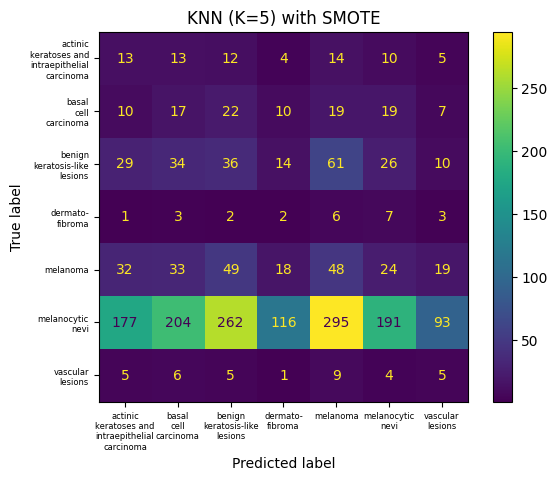

In [100]:
cm = metrics.confusion_matrix(y_true, y_pred)
target_names = ['actinic\nkeratoses and\nintraepithelial\ncarcinoma', 'basal\ncell\ncarcinoma', 'benign\nkeratosis-like\nlesions', 'dermato-\nfibroma', 'melanoma', 'melanocytic\nnevi', 'vascular\nlesions']
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
# plt.xticks(rotation=30)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.yticks(wrap=True)
plt.xticks(wrap=True)
plt.title("KNN (K=5) with SMOTE")
plt.savefig('confusion_matrix_KNN_SMOTE.png', dpi=300)

## Deep Learning

Since the classical machine learning models are not performing that well, it was decided to try a deep learning approach as well. 

In [115]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torcheval.metrics import MulticlassAccuracy
from sklearn import metrics
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator

### Loading the Dataset

For the deep learning models we are going to use the 224x224 sized images. The dataset mean and standard deviation are calculated in advance as mentioned in a previous cell. The statistics are used for normalizing the images. A dataloader is then constructed for each of the training, validation, and test sets.

In [116]:
data_flag = 'dermamnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

BATCH_SIZE = 128

# Dataset mean and standard deviation are to be calcualted at the correct sale at the beginning of the notebook.
dataset_mean = [194.62581872, 137.20409905, 143.19388892] 
dataset_std = [22.24230095, 30.6950007, 34.66692522]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])

# load the data
train_dataset = DataClass(split='train', transform=transform, download=download, size=224, mmap_mode='r')
valid_dataset = DataClass(split='val', transform=transform, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [117]:
print(train_dataset)
print("===================")
print(valid_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 224 (dermamnist_224)
    Number of datapoints: 7007
    Root location: /home/common/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 224 (dermamnist_224)
    Number o

The weight of each class is calculated as the its number of occurances divided by the number of all training labels. This will be used later in the loss function to overcome the data imbalance.

In [118]:
labels = train_dataset.labels.ravel()
counts = []
for i in range(7):
    counts.append(np.sum(labels == i))
class_weights = torch.tensor(counts / np.sum(counts), dtype=torch.float)
class_weights

tensor([0.0325, 0.0512, 0.1097, 0.0114, 0.1112, 0.6698, 0.0141])

We decided to go with a pretrained model approach. The best performing model is the ResNet 50 CNN-based model, and it was pretrained on the ImageNet dataset. All model pretrained weights were frozen except for the last convolutional block, and the fully connected output layer was modified to suit our 7-class dataset.

In [119]:
model = torch.hub.load("pytorch/vision", "resnet50")
num_classes = 7
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)    # For ResNet
# model.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)    # For VGG
# model.heads.head = torch.nn.Linear(num_ftrs, num_classes)   # For ViT

# Freeze all layers except the final FC layer
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
model.fc.requires_grad = True     # For ResNet

Using cache found in /home/common/.cache/torch/hub/pytorch_vision_main


The model is then fine-tuned for 35 epochs with a learning rate of 3x10^-4. The model fine-tuning is done using the GPU for faster processing. Cross entropy loss is used weighted by the class weights. A scheduler is used to scale down the learning rate to slow down the learning steps to converge better. The resulting model is then saved as a checkpoint to be able to load it and use it again later directly. 

In [120]:
NUM_EPOCHS = 35
LR = 3e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
train_metric = MulticlassAccuracy()
val_metric = MulticlassAccuracy()

training_acc_epochs = []
valid_acc_epochs = []

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    for inputs, labels in train_loader:
        training_acc_batch = []
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_metric.update(torch.argmax(outputs, dim=1), labels)
        training_acc_batch.append(train_metric.compute())
    training_acc_epochs.append(np.mean(training_acc_batch))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        for inputs, labels in valid_loader:
            valid_acc_batch = []
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            val_metric.update(torch.argmax(outputs, dim=1), labels)
            valid_acc_batch.append(val_metric.compute())
    valid_acc_epochs.append(np.mean(valid_acc_batch))
    # print(f"Epoch {epoch}: Train Accuracy = {training_acc_epochs[-1]:.4f}     Val Acc = {valid_acc_epochs[-1]:.4f}")

torch.save(model.state_dict(), "fine_tuned_resnet50_35_Adam_3e4.pth")

100%|██████████| 35/35 [04:54<00:00,  8.41s/it]


The training and validation accuracies are plotted against the number of epochs to monitor overfitting.

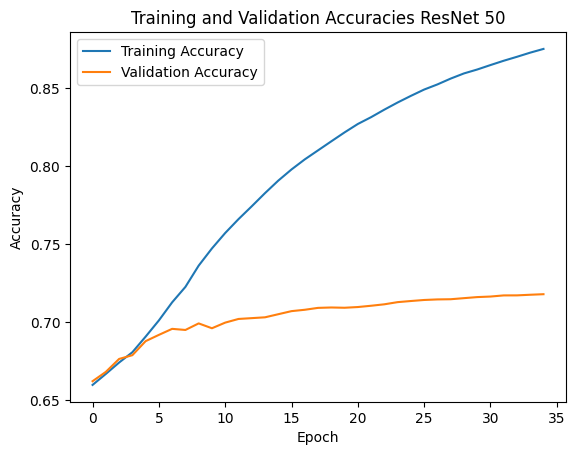

In [121]:
# Plotting the evolution of loss
fig, ax = plt.subplots()
ax.plot(training_acc_epochs, label='Training Accuracy')
ax.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies ResNet 50')
plt.legend()
plt.savefig('accuracies_resnet50.png', dpi=300)

In [122]:
y_true = np.array([])
y_pred = np.array([])
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.squeeze(1)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    y_true = np.append(y_true, labels.cpu().numpy())
    y_pred = np.append(y_pred, preds.cpu().numpy())
y_true = y_true.ravel()
y_pred = y_pred.ravel()

In [123]:
target_names = ['actinic keratoses and intraepithelial carcinoma', 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
print(metrics.classification_report(y_true, y_pred, zero_division=0, target_names=target_names))

                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.36      0.39      0.38        66
                           basal cell carcinoma       0.36      0.50      0.42       103
                  benign keratosis-like lesions       0.54      0.38      0.44       220
                                 dermatofibroma       0.00      0.00      0.00        23
                                       melanoma       0.38      0.35      0.36       223
                               melanocytic nevi       0.85      0.91      0.88      1341
                               vascular lesions       0.33      0.03      0.06        29

                                       accuracy                           0.72      2005
                                      macro avg       0.40      0.36      0.36      2005
                                   weighted avg       0.70      0.72      0.71      2005



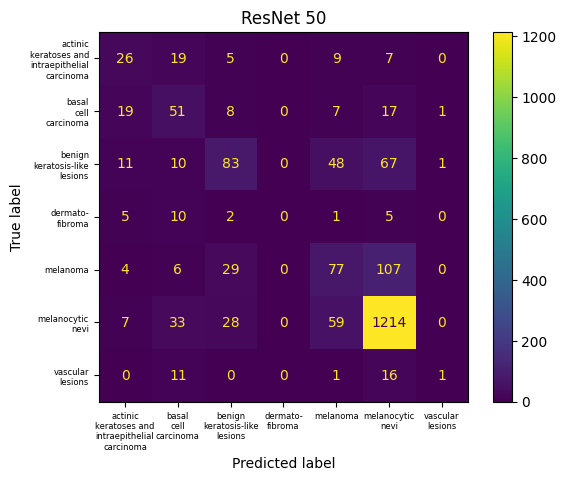

In [124]:
target_names = ['actinic\nkeratoses and\nintraepithelial\ncarcinoma', 'basal\ncell\ncarcinoma', 'benign\nkeratosis-like\nlesions', 'dermato-\nfibroma', 'melanoma', 'melanocytic\nnevi', 'vascular\nlesions']
cm = metrics.confusion_matrix(y_true, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
# plt.xticks(rotation=30)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.yticks(wrap=True)
plt.xticks(wrap=True)
plt.title("ResNet 50")
plt.savefig('confusion_matrix_resnet50.png', dpi=300)